In [1]:
import tensorflow as tf
import pickle

2023-07-29 21:58:20.210821: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
with open("..//data//valid_items.pickle", "rb") as f:
    valid_items = pickle.load( f)

In [3]:
valid_gcn_feats, valid_adj_list,omics_gen_copy_number_gen_expr_valid, omics_gen_methyl_valid, omics_gen_mut_valid = valid_items[0]
y_valid = valid_items[1]

In [4]:
from tensorflow.keras import backend as K

In [5]:
# from tensorflow.keras import backend as K

In [6]:
# combo_cdr_gcn_more_dropout_trained_and_activated

In [7]:
simplecdr = tf.keras.models.load_model("..//Models//combo_cdr_gcn_more_dropout_trained_and_activated")

2023-07-29 21:58:23.189564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 21:58:23.690661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78910 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:31:00.0, compute capability: 8.0


In [8]:
training, dropout1, dropout2 = True, 0.2, 0.2

In [9]:
def deepcdrgcn(training = training, dropout1 = dropout1, dropout2 = dropout2):
    input_gcn_features = tf.keras.layers.Input(shape = (100, 75))
    input_norm_adj_mat = tf.keras.layers.Input(shape = (100, 100))
    mult_1 = tf.keras.layers.Dot(1)([input_norm_adj_mat, input_gcn_features])
    dense_layer_gcn = tf.keras.layers.Dense(256, activation = "relu")
    dense_out = dense_layer_gcn(mult_1)
    dense_out = tf.keras.layers.BatchNormalization()(dense_out)
    dense_out = tf.keras.layers.Dropout(dropout1)(dense_out, training = training)
    mult_2 = tf.keras.layers.Dot(1)([input_norm_adj_mat, dense_out])
    dense_layer_gcn = tf.keras.layers.Dense(256, activation = "relu")
    dense_out = dense_layer_gcn(mult_2)
    dense_out = tf.keras.layers.BatchNormalization()(dense_out)
    dense_out = tf.keras.layers.Dropout(dropout1)(dense_out, training = training)

    dense_layer_gcn = tf.keras.layers.Dense(100, activation = "relu")
    mult_3 = tf.keras.layers.Dot(1)([input_norm_adj_mat, dense_out])
    dense_out = dense_layer_gcn(mult_3)
    dense_out = tf.keras.layers.BatchNormalization()(dense_out)
    dense_out = tf.keras.layers.Dropout(dropout1)(dense_out, training = training)

    dense_out = tf.keras.layers.GlobalAvgPool1D()(dense_out)
    input_gen_expr = tf.keras.layers.Input(shape = (691,2))
    
    l1 = tf.keras.layers.Dense(32)(input_gen_expr)
    l1 = tf.keras.layers.Dropout(dropout1)(l1, training = training)
    l2 = tf.keras.layers.Dense(128)(l1)
    l2 = tf.keras.layers.Dropout(dropout1)(l2, training = training)
    
    dense_layer_gcn1 = tf.keras.layers.Dense(256, activation = "relu")
    dense_out1 = dense_layer_gcn1(l2)
    dense_out1 = tf.keras.layers.BatchNormalization()(dense_out1)
    dense_out1 = tf.keras.layers.Dropout(dropout1)(dense_out1, training = training)
# mult_21 = tf.keras.layers.Dot(1)([const_input, dense_out1])
    dense_layer_gcn1 = tf.keras.layers.Dense(256, activation = "relu")
    dense_out1 = dense_layer_gcn1(dense_out1)
    dense_out1 = tf.keras.layers.BatchNormalization()(dense_out1)
    dense_out1 = tf.keras.layers.Dropout(dropout1)(dense_out1, training = training)
    dense_layer_gcn1 = tf.keras.layers.Dense(256, activation = "relu")
    dense_out1 = dense_layer_gcn1(dense_out1)
    dense_out1 = tf.keras.layers.BatchNormalization()(dense_out1)
    dense_out1 = tf.keras.layers.Dropout(dropout1)(dense_out1, training = training)
    dense_layer_gcn1 = tf.keras.layers.Dense(256, activation = "relu")
    dense_out1 = dense_layer_gcn1(dense_out1)
    dense_out1 = tf.keras.layers.BatchNormalization()(dense_out1)
    dense_out1 = tf.keras.layers.Dropout(dropout1)(dense_out1, training = training)
    dense_out1 = tf.keras.layers.GlobalAvgPool1D()(dense_out1)
    
    input_gen_methy = tf.keras.layers.Input(shape = (808,))
    gen_methy_layer = tf.keras.layers.Dense(256, activation = "tanh")
    
    gen_methy_emb = gen_methy_layer(input_gen_methy)
    gen_methy_emb = tf.keras.layers.BatchNormalization()(gen_methy_emb)
    gen_methy_emb = tf.keras.layers.Dropout(dropout1)(gen_methy_emb, training = training)
    gen_methy_layer = tf.keras.layers.Dense(100, activation = "relu")
    gen_methy_emb = gen_methy_layer(gen_methy_emb)
    
    input_gen_mut = tf.keras.layers.Input(shape = (34673,))
    
    reshape_gen_mut = tf.keras.layers.Reshape((1, 34673, 1))
    reshape_gen_mut = reshape_gen_mut(input_gen_mut)
    gen_mut_layer = tf.keras.layers.Conv2D(50, (1, 700), strides=5, activation = "tanh")
    gen_mut_emb = gen_mut_layer(reshape_gen_mut)
    pool_layer = tf.keras.layers.MaxPooling2D((1,5))
    pool_out = pool_layer(gen_mut_emb)
    gen_mut_layer = tf.keras.layers.Conv2D(30, (1, 5), strides=2, activation = "relu")
    gen_mut_emb = gen_mut_layer(pool_out)
    pool_layer = tf.keras.layers.MaxPooling2D((1,10))
    pool_out = pool_layer(gen_mut_emb)
    flatten_layer = tf.keras.layers.Flatten()
    flatten_out = flatten_layer(pool_out)
    all_omics = tf.keras.layers.Concatenate()([gen_methy_emb, flatten_out, dense_out1, dense_out])
    x = tf.keras.layers.Dense(300,activation = 'tanh')(all_omics)
    x = tf.keras.layers.Dropout(dropout1)(x, training = training)
    x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x,axis=-1))(x)
    x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x,axis=1))(x)
    x = tf.keras.layers.Conv2D(filters=30, kernel_size=(1,150),strides=(1, 1), activation = 'relu',padding='valid')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1,2))(x)
    x = tf.keras.layers.Conv2D(filters=10, kernel_size=(1,5),strides=(1, 1), activation = 'relu',padding='valid')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1,3))(x)
    x = tf.keras.layers.Conv2D(filters=5, kernel_size=(1,5),strides=(1, 1), activation = 'relu',padding='valid')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1,3))(x)
    x = tf.keras.layers.Dropout(dropout1)(x, training = training)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(dropout2)(x, training = training)
    final_out_layer = tf.keras.layers.Dense(1)
    final_out = final_out_layer(x)
    simplecdr = tf.keras.models.Model([input_gcn_features, input_norm_adj_mat, input_gen_expr,
                                   input_gen_methy, input_gen_mut], final_out)
    # simplecdr.compile(loss = tf.keras.losses.MeanSquaredError(), 
    #                   # optimizer = tf.keras.optimizers.Adam(lr=1e-3),
    #                 optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
    #                 metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    return simplecdr

In [10]:
y_valid = y_valid.reshape(-1,1)

In [11]:
import numpy as np

In [12]:
import gc

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
# y_valid.shape

In [15]:
def get_one_preds(training, dropout1, dropout2):
    with tf.device('/gpu:0'):
        simplecdr1 = deepcdrgcn(training, dropout1, dropout2)
        simplecdr1.set_weights(simplecdr.get_weights())
        preds = simplecdr1.predict([ valid_gcn_feats, valid_adj_list,
                           omics_gen_copy_number_gen_expr_valid, 
                           omics_gen_methyl_valid, omics_gen_mut_valid], batch_size = 2048, verbose = 0)
        # print(preds.shape)
        rmse = np.sqrt(mean_squared_error(preds, y_valid))
        # print(i)
        # print(rmse)
        
    # K.clear_session()
    # gc.collect()
    return preds

In [16]:
# np.array(preds).shape

In [17]:
from scipy.stats import pearsonr

In [18]:
drop_rates = np.array(list(range(1, 20, 1)))/20

In [19]:
drop_rates = np.hstack((drop_rates, np.array([0.99])))

In [20]:
drop_rates = drop_rates.tolist()

In [21]:
# drop_rates

In [22]:
overall_catch = []
for drop in drop_rates:
    # drop_rate = drop/10.0
    preds = []
    for i in range(0, 20): 
    # with tf.device('/gpu:0'):
        preds.append(get_one_preds(training, drop, drop))
        K.clear_session()
        gc.collect()
    stacked_preds = np.array(preds)
    y_valid_avg_preds = stacked_preds.mean(0)
    rmse = np.sqrt(mean_squared_error(y_valid_avg_preds, y_valid))
    res = pearsonr(y_valid_avg_preds[:,0], y_valid[:,0])
    pearson = res[0]
    li = np.percentile(stacked_preds, axis = 0, q = (2.5, 97.5))[0,:,:]
    ui = np.percentile(stacked_preds, axis = 0, q = (2.5, 97.5))[1,:,:]
    ind = (y_valid >= li) & (y_valid <= ui)
    coverage = ind.mean()
    width = ui - li
    avg_width = width.mean()
    overall_catch.append([drop, rmse, pearson, coverage, avg_width])
    print([drop, rmse, pearson, coverage, avg_width])

2023-07-29 21:58:28.656761: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-29 21:58:28.785724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


[0.05, 1.1054457385942391, 0.9208741630666942, 0.3843843843843844, 1.0155718131423284]
[0.1, 1.1078616464211624, 0.9208306962611533, 0.5125895125895126, 1.4626555633917708]
[0.15, 1.1138350038011715, 0.920550550143054, 0.6072418572418572, 1.8367901596395808]
[0.2, 1.1263805038192072, 0.919555328375972, 0.6716331716331716, 2.1867812916043547]
[0.25, 1.1495319446061956, 0.9175199748227953, 0.7233772233772233, 2.5360516997670794]
[0.3, 1.1773586777639056, 0.915432323366971, 0.7707900207900208, 2.8973257830028727]
[0.35, 1.221695574831091, 0.9114661150684917, 0.8038808038808039, 3.2824564248307087]
[0.4, 1.2800995652375458, 0.9066602829201358, 0.8326403326403327, 3.7268910756824734]
[0.45, 1.3710236664429518, 0.8982933023021147, 0.8537768537768538, 4.231768518392504]
[0.5, 1.5004529107674578, 0.8838932953031423, 0.8676946176946176, 4.849296993981091]
[0.55, 1.6635728925440525, 0.8646764158908329, 0.8763571263571264, 5.5881341304247085]
[0.6, 1.8831396440185142, 0.832114722462815, 0.8809193

In [23]:
import pandas as pd

In [24]:
overall_catch_df = pd.DataFrame(overall_catch)

In [25]:
overall_catch_df.columns = ["drop_proportion", "rmse", "pearsonr", "coverage", "avg_width"]

In [26]:
overall_catch_df.to_csv("..//data//metrics_for_different_drop_rates_rep_1.csv", index = False)

In [27]:
overall_catch_df.head()

,drop_proportion,rmse,pearsonr,coverage,avg_width
0,0.05,1.105446,0.920874,0.384384,1.015572
1,0.10,1.107862,0.920831,0.512590,1.462656
2,0.15,1.113835,0.920551,0.607242,1.836790
3,0.20,1.126381,0.919555,0.671633,2.186781
4,0.25,1.149532,0.917520,0.723377,2.536052


In [28]:
overall_catch_df

,drop_proportion,rmse,pearsonr,coverage,avg_width
0,0.05,1.105446,0.920874,0.384384,1.015572
1,0.10,1.107862,0.920831,0.512590,1.462656
2,0.15,1.113835,0.920551,0.607242,1.836790
3,0.20,1.126381,0.919555,0.671633,2.186781
4,0.25,1.149532,0.917520,0.723377,2.536052
5,0.30,1.177359,0.915432,0.770790,2.897326
6,0.35,1.221696,0.911466,0.803881,3.282456
7,0.40,1.280100,0.906660,0.832640,3.726891
8,0.45,1.371024,0.898293,0.853777,4.231769
9,0.50,1.500453,0.883893,0.867695,4.849297


In [29]:
import matplotlib.pyplot as plt

In [30]:
how_many = 15

In [31]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

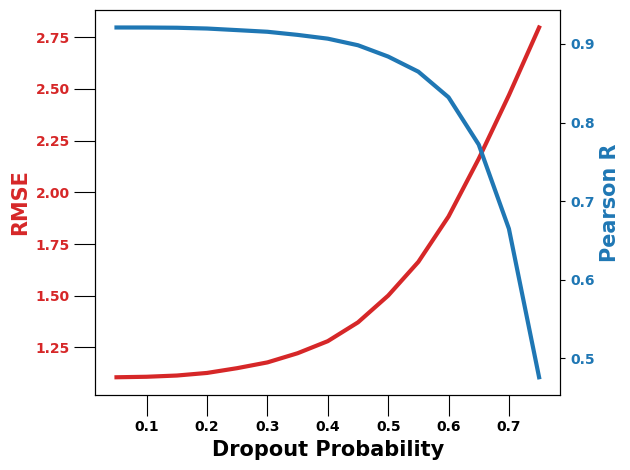

In [32]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Dropout Probability', fontsize = 15, fontweight = "bold")
ax1.set_ylabel('RMSE', color=color, fontsize = 15, fontweight = "bold")
ax1.plot(overall_catch_df.iloc[:how_many,:]['drop_proportion'], overall_catch_df.iloc[:how_many,:]['rmse'], color=color, linewidth = 3)
ax1.tick_params(axis='y', labelcolor=color, size = 15)
ax1.tick_params(axis='x', labelcolor="black", size = 15)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax1.set_xlabel('Dropout Probability')
ax2.set_ylabel('Pearson R', color=color, fontsize = 15, fontweight = "bold")
ax2.plot(overall_catch_df.iloc[:how_many,:]['drop_proportion'], overall_catch_df.iloc[:how_many,:]['pearsonr'], color=color, linewidth = 3)
ax2.tick_params(axis='y', labelcolor=color)

# plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
# plt.ylabel("Model Weight", fontsize = 15, fontweight = "bold")
# plt.xticks( fontsize = 10, fontweight = "bold")
# plt.yticks( fontsize = 10, fontweight = "bold")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

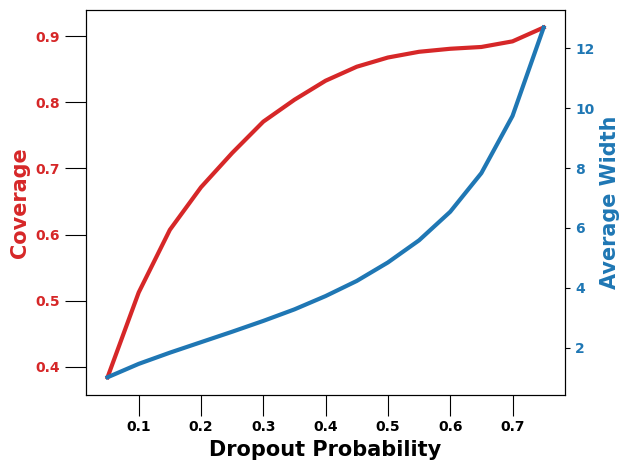

In [33]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Dropout Probability', fontsize = 15, fontweight = "bold")
ax1.set_ylabel('Coverage', color=color, fontsize = 15, fontweight = "bold")
ax1.plot(overall_catch_df.iloc[:how_many,:]['drop_proportion'], overall_catch_df.iloc[:how_many,:]['coverage'], color=color, linewidth = 3)
ax1.tick_params(axis='y', labelcolor=color, size = 15)
ax1.tick_params(axis='x', labelcolor="black", size = 15)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax1.set_xlabel('Dropout Probability')
ax2.set_ylabel('Average Width', color=color, fontsize = 15, fontweight = "bold")
ax2.plot(overall_catch_df.iloc[:how_many,:]['drop_proportion'], overall_catch_df.iloc[:how_many,:]['avg_width'], color=color, linewidth = 3)
ax2.tick_params(axis='y', labelcolor=color)

# plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
# plt.ylabel("Model Weight", fontsize = 15, fontweight = "bold")
# plt.xticks( fontsize = 10, fontweight = "bold")
# plt.yticks( fontsize = 10, fontweight = "bold")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()